# Overview

This notebook shows how to run a molecular dymanics simulation on alanine dipeptide and analyse the simulation data using MFI to determine the free energy surface.

The notebook will be structured as follows:

 - Running a Alanine Dipeptide simulation with Metadynamics
 - Using Mean Force Integration to analyse the data
 - Running a Metadynaics simulation with umbrella sampling

Some concepts and functions have been introduced in previous notebooks. Please refere to previous notebooks for more information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
import statistics
import scipy.integrate as integrate
import plumed
import pandas as pd
from labellines import labelLines
from labellines import labelLine
from timeit import default_timer as timer
from scipy import interpolate
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess


import scipy.io
import matplotlib as mpl

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 14})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

In [2]:
# os.chdir(path)
#Import modules like numpy and matplotlib as well as functions defined in Functions.ipynb
%run Functions.ipynb

#make sure to run this cell in the right directory!!
path = os.getcwd()
print("The path to this notebook is:", path)

The path to this notebook is: /home/antoniu/Desktop/Public_Notebooks


In [4]:
#make sure to run this cell in the right directory!!
try: os.mkdir("Alanine_Dipeptide")
except: print("folder \"Alanine_Dipeptide\" already exists")
os.chdir("Alanine_Dipeptide")

folder "Alanine_Dipeptide" already exists


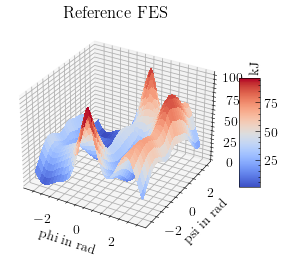

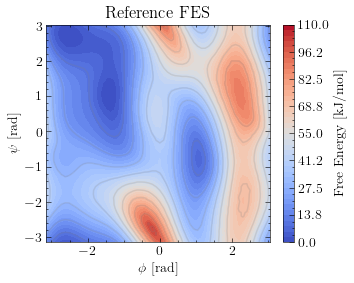

In [5]:
data = np.genfromtxt('fes_ap_10E9.dat') 

FREF=np.reshape(data[:,2],(60,60));
XREF=np.reshape(data[:,0],(60,60));
YREF=np.reshape(data[:,1],(60,60));

FREF = FREF - np.min(FREF)

#Change value of pi. min(XREF) is too small
XREF[XREF == -3.141593] = -np.pi
YREF[YREF == -3.141593] = -np.pi

fes3d = plt.figure(1)
ax = fes3d.gca(projection='3d')
surf = ax.plot_surface(XREF, YREF, FREF, cmap="coolwarm", linewidth=0, antialiased=False)
fes3d.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Reference FES")
ax.set_xlabel('phi in rad')
ax.set_ylabel('psi in rad')
ax.set_zlabel('Free energy in kJ')

plt.figure(2)
plt.contourf(XREF, YREF, FREF, levels=np.linspace(0,110,41), cmap='coolwarm')
plt.colorbar(label="Free Energy [kJ/mol]");
plt.contour(XREF, YREF, FREF, levels=np.linspace(0,100,11), alpha=0.2, colors="grey")
plt.title("Reference FES")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/FES_AP_ref.png', dpi=600, bbox_inches='tight')

plt.show()

# Metadynamics Simulation with MFI

In [6]:
#Define constants #######
bw = 0.05; bw2 = bw**2        # bw: bandwidth for the KDE of the biased probability density
kT = 2.49         

# define grid and analytical FES  #############
nbins = 201 # number of bin in grid  
min_grid = -np.pi
max_grid = np.pi
grid_space = (max_grid - min_grid) / (nbins - 1)
grid = np.linspace(min_grid,max_grid,nbins)
X, Y = np.meshgrid(grid, grid)

#Use periodic extension for defining PBC
periodic_extension = 1 / 2
grid_ext = (1/2) * periodic_extension * (max_grid-min_grid)
Flim=50

In [7]:
def find_periodic_point(x_coord,y_coord):
    coord_list = []
    #There are potentially 4 points, 1 original and 3 periodic copies
    coord_list.append([x_coord,y_coord])
    copy_record = [0,0,0,0]
    #check for x-copy
    if x_coord < min_grid+grid_ext:
        coord_list.append([x_coord + 2*np.pi,y_coord])
        copy_record[0] = 1
    elif x_coord > max_grid-grid_ext:
        coord_list.append([x_coord - 2*np.pi,y_coord])
        copy_record[1] = 1
    #check for y-copy
    if y_coord < min_grid+grid_ext:
        coord_list.append([x_coord, y_coord + 2 * np.pi])
        copy_record[2] = 1
    elif y_coord > max_grid-grid_ext:
        coord_list.append([x_coord, y_coord - 2 * np.pi])
        copy_record[3] = 1
    #check for xy-copy
    if sum(copy_record) == 2:
        if copy_record[0] == 1 and copy_record[2] == 1: coord_list.append([x_coord + 2 * np.pi, y_coord + 2 * np.pi])
        elif copy_record[1] == 1 and copy_record[2] == 1: coord_list.append([x_coord - 2 * np.pi, y_coord + 2 * np.pi])
        elif copy_record[0] == 1 and copy_record[3] == 1: coord_list.append([x_coord + 2 * np.pi, y_coord - 2 * np.pi])
        elif copy_record[1] == 1 and copy_record[3] == 1: coord_list.append([x_coord - 2 * np.pi, y_coord - 2 * np.pi])

    return coord_list


def find_cutoff_matrix(input_FES):
    len_x, len_y = np.shape(input_FES)
    cutoff_matrix = np.ones((len_x, len_y))
    for ii in range(len_x):
        for jj in range(len_y):
            if input_FES[ii][jj] >= Flim: cutoff_matrix[ii][jj] = 0
    return cutoff_matrix


def zero_to_nan(input_array):
    len_x, len_y = np.shape(input_array)
    for ii in range(len_x):
        for jj in range(len_y):
            if input_array[ii][jj] == 0: input_array[ii][jj] = float("Nan")
    return input_array


def find_FES_adj(X_old, Y_old, FES_old):
    # r = np.stack(["x_old_grid_mesh".ravel(), "y_old_grid_mesh".ravel()]).T
    r = np.stack([X_old.ravel(), Y_old.ravel()]).T
    # Sx = interpolate.CloughTocher2DInterpolator(r, "Z_values".ravel())
    Sx = interpolate.CloughTocher2DInterpolator(r, FES_old.ravel())
    # ri = np.stack(["x_new_grid_mesh".ravel(), "y_new_grid_mesh".ravel()]).T
    ri = np.stack([XREF.ravel(), YREF.ravel()]).T
    FES_new = Sx(ri).reshape(XREF.shape)

    return FES_new

def FFT_intg_2D(FX, FY, i_bins=(nbins,nbins)):

    if i_bins == (nbins,nbins):
        freq_1d = np.fft.fftfreq(nbins, grid_space)
        freq_x, freq_y = np.meshgrid(freq_1d, freq_1d)

    else: #interpolate
        grid_new_x = np.linspace(grid.min(), grid.max(), i_bins[0])
        grid_new_y = np.linspace(grid.min(), grid.max(), i_bins[1])
        X_new, Y_new = np.meshgrid(grid_new_x, grid_new_y)
        grid_space_x = (grid.max() - grid.min()) / (i_bins[0] - 1)
        grid_space_y = (grid.max() - grid.min()) / (i_bins[1] - 1)

        r = np.stack([X.ravel(), Y.ravel()]).T
        Sx = interpolate.CloughTocher2DInterpolator(r, FX.ravel())
        Sy = interpolate.CloughTocher2DInterpolator(r, FY.ravel())
        ri = np.stack([X_new.ravel(), Y_new.ravel()]).T

        FX = Sx(ri).reshape(X_new.shape)
        FY = Sy(ri).reshape(Y_new.shape)

        freq_1d_x = np.fft.fftfreq(i_bins[0], grid_space_x)
        freq_1d_y = np.fft.fftfreq(i_bins[1], grid_space_y)
        freq_x, freq_y = np.meshgrid(freq_1d_x, freq_1d_y)


    freq_hypot = np.hypot(freq_x, freq_y)
    freq_sq = np.where(freq_hypot != 0, freq_hypot ** 2, 1E-10)

    fourier_x = (np.fft.fft2(FX) * freq_x) / (2 * np.pi * 1j * freq_sq)
    fes_x = np.real(np.fft.ifft2(fourier_x))

    fourier_y = (np.fft.fft2(FY) * freq_y) / (2 * np.pi * 1j * freq_sq)
    fes_y = np.real(np.fft.ifft2(fourier_y))

    fes = fes_x + fes_y
    fes = fes - np.min(fes)
    
    if i_bins == (nbins, nbins): return fes
    else: return (X_new, Y_new, fes)
    
    
#Integration M.S.    
def MS_intg_2d(FX, FY):   

    SdZx = np.cumsum(FX, axis=1) * grid_space  # cumulative sum along x-axis
    SdZy = np.cumsum(FY, axis=0) * grid_space  # cumulative sum along y-axis
    fes = np.zeros(SdZx.shape)
    for i in range(FES.shape[0]):
        for j in range(FES.shape[1]):
            fes[i, j] += np.sum([SdZy[i, 0], -SdZy[0, 0], SdZx[i, j], -SdZx[i, 0]])
    fes = fes - np.min(fes)     
    
    return fes


def patch2D_error():
    return_true = 0
    len_master = len(Ftot_master)
    len_patch = len(Ftot_patch)
    while len_master > len_patch:
        return_true = 1
        
        Ftot_x = np.zeros((nbins, nbins))
        Ftot_y = np.zeros((nbins, nbins))
        Ftot_den = np.zeros((nbins, nbins))
        Ftot_den2 = np.zeros((nbins, nbins))
        ofv_x = np.zeros((nbins, nbins))
        ofv_y = np.zeros((nbins, nbins))
        error_x = np.zeros((nbins, nbins))
        error_y = np.zeros((nbins, nbins))

        for i in range(len_patch + 1):
            Ftot_x += Ftot_master[i][0] * Ftot_master[i][2]
            Ftot_y += Ftot_master[i][0] * Ftot_master[i][3]
            Ftot_den += Ftot_master[i][0]
            Ftot_den2 += Ftot_master[i][1]
            ofv_x += Ftot_master[i][4]
            ofv_y += Ftot_master[i][5]
            error_x += Ftot_master[i][0] * (Ftot_master[i][2]**2)
            error_y += Ftot_master[i][0] * (Ftot_master[i][3]**2)

        Ftot_x = np.divide(Ftot_x, Ftot_den, out=np.zeros_like(Ftot_x), where=Ftot_den != 0)
        Ftot_y = np.divide(Ftot_y, Ftot_den, out=np.zeros_like(Ftot_y), where=Ftot_den != 0)
        
                
        error_x = np.divide(error_x, Ftot_den, out=np.zeros_like(error_x), where=Ftot_den != 0) - (Ftot_x**2)
        error_y = np.divide(error_y, Ftot_den, out=np.zeros_like(error_y), where=Ftot_den != 0) - (Ftot_y**2)
        
        ratio = np.divide(Ftot_den2, (Ftot_den**2 - Ftot_den2), out=np.zeros_like(error_x), where=(Ftot_den**2 - Ftot_den2) != 0)
        error_x = error_x * ratio
        error_y = error_y * ratio
        
        error = np.sqrt(np.sqrt(error_x**2 + error_y**2))

        
        Ftot_patch.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
        len_master = len(Ftot_master)
        len_patch = len(Ftot_patch)

        FES = FFT_intg_2D(Ftot_x, Ftot_y)
        
        # print("shape FES: " , np.shape(FES_a))
        if len(FES) == len(X): FES_adj = find_FES_adj(X, Y, FES)
        else: FES_adj = find_FES_adj(X_new,Y_new, FES_a)
        FES_adj = FES_adj - np.min(FES_adj)

        # Find cutoff matrix for FES_adj > Flim
        cutoff_adj = find_cutoff_matrix(FES_adj)

        # Calculate FES error to FREF[60x60]
        FES_error = abs(FES_adj - FREF) * cutoff_adj
        FES_error_uncut_a = abs(FES_adj - FREF)
        error_patch.append(sum(sum(FES_error)) / (np.count_nonzero(FES_error)))

        # Find cutoff matrix for FES > Flim
        cutoff = find_cutoff_matrix(FES)
        sd_patch.append(sum(sum(error*cutoff)) / np.count_nonzero(cutoff) )

        print("AAD (to FREF) is: " + str(error_patch[-1]) )
        print("Average standard error is: " + str(sd_patch[-1]))
        print("With non-zero ratio: ", np.count_nonzero(cutoff) / (np.shape(cutoff)[0] * np.shape(cutoff)[1]))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")


    if return_true == 1:
        return [FES, FES_error]
    
    
def patch_to_base_error(master0, master):
    
    [PD0, PD20, FX0, FY0, OFV_X0, OFV_Y0] = master0
    [PD, PD2, FX, FY, OFV_X, OFV_Y] = master

    FX_patch = PD0 * FX0 + PD * FX
    FY_patch = PD0 * FY0 + PD * FY
    
    PD_patch = PD0 + PD
    PD2_patch = PD20 + PD2
    OFV_X_patch = OFV_X0 + OFV_X
    OFV_Y_patch =  OFV_Y0 + OFV_Y
    
    FX_patch = np.divide(FX_patch, PD_patch, out=np.zeros_like(FX_patch), where=PD_patch > 1E-100)
    FY_patch = np.divide(FY_patch, PD_patch, out=np.zeros_like(FY_patch), where=PD_patch > 1E-100)
    
#     Ftot_patch.append([PD_patch, PD2_patch, FX_patch, FY_patch, OFV_X_patch, OFV_Y_patch])
    
    PD_ratio = np.divide(PD2_patch, (PD_patch**2 - PD2_patch), out=np.zeros_like(PD_patch), where=(PD_patch**2 - PD2_patch) != 0)
    OFE_X = np.divide(OFV_X_patch, PD_patch, out=np.zeros_like(OFV_X_patch), where=PD_patch > 1E-100) - FX_patch**2
    OFE_Y = np.divide(OFV_Y_patch, PD_patch, out=np.zeros_like(OFV_Y_patch), where=PD_patch > 1E-100) - FY_patch**2

    OFE_X = OFE_X * PD_ratio
    OFE_Y = OFE_Y * PD_ratio
    OFE = np.sqrt(np.sqrt(OFE_X**2 + OFE_Y**2))
    
    #integrate Ftot to find FES
    fes = FFT_intg_2D(FX_patch, FY_patch)
    #Find adjusted FES (60x60) to compare to reference FES (60x60)
    FES_adj = find_FES_adj(X, Y, fes)
    FES_adj = FES_adj - np.min(FES_adj)
    #Find cutoff matrix for FES_adj > Flim
    cutoff = find_cutoff_matrix(FES_adj)
    # Calculate FES, only take every 5th (factor) value to comopare to fes[60x60]
    FES_error = abs(FES_adj - FREF) * cutoff
    ad_history.append(sum(sum(FES_error)) / (np.count_nonzero(FES_error)))
    ad_centre_history.append(sum(sum(reduce_to_centre_plumed(FES_error))) / (np.count_nonzero(reduce_to_centre_plumed(FES_error))))

    
    # Find cutoff matrix for FES > Flim
    cutoff = find_cutoff_matrix(fes)
    #calculate ofe with cutoff
    OFE = np.array(OFE*cutoff)
    ofe_history.append(sum(sum(OFE)) / (np.count_nonzero(OFE)))
    ofe_centre_history.append(sum(sum(reduce_to_centre(OFE))) / (np.count_nonzero(reduce_to_centre(OFE))))
    
    ratio_history.append(np.count_nonzero(cutoff)/(nbins*nbins))
    ratio_centre_history.append(np.count_nonzero(reduce_to_centre(cutoff))/ (np.shape(reduce_to_centre(cutoff))[0]*np.shape(reduce_to_centre(cutoff))[1] ))

    print("AAD (to FREF) is: " + str(ad_history[-1]) + " [" + str(ad_centre_history[-1]) + "]")
    print("ofe is: "  + str(ofe_history[-1]) + " [" + str(ofe_centre_history[-1]) + "]")
    print("With non-zero ratio: " , ratio_history[-1] , " [" , ratio_centre_history[-1] , "]")
    print("\n")
    
    return [FES, FES_error]
    
def index(position):
    return int((position-min_grid)//(XREF[0][1]-XREF[0][0]))+1

def index_g(position):
    return int((position-min_grid)//grid_space)+1


def reduce_to_centre(input_array, cx_min=-0.5, cx_max=0.5, cy_min=-1.5, cy_max=1.5):
    return input_array[index_g(cy_min): index_g(cy_max), index_g(cx_min): index_g(cx_max)]

def reduce_to_centre_plumed(input_array, cx_min=-0.5, cx_max=0.5, cy_min=-1.5, cy_max=1.5):
    return input_array[index(cy_min): index(cy_max), index(cx_min): index(cx_max)]


Total no. of HILLS for following simulation: 4000


<ipython-input-8-bd2cccb1ed76>:123: RuntimeWarning: invalid value encountered in double_scalars
  ad_centre_history.append(sum(sum(reduce_to_centre_plumed(FES_error))) / (np.count_nonzero(reduce_to_centre_plumed(FES_error))))
<ipython-input-8-bd2cccb1ed76>:140: RuntimeWarning: invalid value encountered in double_scalars
  ofe_centre_history.append(sum(sum(reduce_to_centre(ofe))) / (np.count_nonzero(reduce_to_centre(ofe))))


50 / 4000
AAD (to FREF) is: 6.133126198450811 [nan]
ofe is: 90.95684434533885 [nan]
With non-zero ratio:  0.2090789831934853  [ 0.0 ]


100 / 4000
AAD (to FREF) is: 4.991130096126291 [nan]
ofe is: 68.95428691380346 [nan]
With non-zero ratio:  0.2219994554590233  [ 0.0 ]


150 / 4000
AAD (to FREF) is: 4.116416716156864 [nan]
ofe is: 65.10236793905287 [nan]
With non-zero ratio:  0.2610331427439915  [ 0.0 ]


200 / 4000
AAD (to FREF) is: 3.4812441089024944 [nan]
ofe is: 62.05825094667143 [127.24324547480107]
With non-zero ratio:  0.26811217544120197  [ 0.0027164685908319186 ]


250 / 4000
AAD (to FREF) is: 3.3445778675462314 [nan]
ofe is: 51.30534000925331 [139.46535348496027]
With non-zero ratio:  0.2705378579738125  [ 0.0023769100169779285 ]


300 / 4000
AAD (to FREF) is: 3.243300788149812 [nan]
ofe is: 46.841858993119786 [92.77422056910184]
With non-zero ratio:  0.27764164253360063  [ 0.0030560271646859084 ]


350 / 4000
AAD (to FREF) is: 3.06080878973156 [nan]
ofe is: 44.1428856665203

2400 / 4000
AAD (to FREF) is: 1.7827875637679762 [3.355436189241387]
ofe is: 35.022752069242806 [77.0995755294029]
With non-zero ratio:  0.5846637459468825  [ 0.6346349745331069 ]


2450 / 4000
AAD (to FREF) is: 1.7354011592230867 [3.3363712627571847]
ofe is: 33.186068258609964 [74.1408408765004]
With non-zero ratio:  0.5872626915175367  [ 0.633616298811545 ]


2500 / 4000
AAD (to FREF) is: 1.6989872407099769 [3.3608215127836476]
ofe is: 32.95392699783877 [73.34471013075321]
With non-zero ratio:  0.5876834731813569  [ 0.631578947368421 ]


2550 / 4000
AAD (to FREF) is: 1.6446684240059328 [3.3367614468615123]
ofe is: 31.981014844708394 [69.2157672041659]
With non-zero ratio:  0.5870646766169154  [ 0.6302207130730051 ]


2600 / 4000
AAD (to FREF) is: 1.573471826762427 [3.15091845750497]
ofe is: 31.676643440752375 [68.74655179797504]
With non-zero ratio:  0.5876834731813569  [ 0.6278438030560272 ]


2650 / 4000
AAD (to FREF) is: 1.5202367100655254 [3.040543210246375]
ofe is: 31.3034871052

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


4000 / 4000
AAD (to FREF) is: 1.4842367028181003 [2.6880700222821092]
ofe is: 25.354005569045853 [61.358163123968524]
With non-zero ratio:  0.6145639959406946  [ 0.7426146010186757 ]




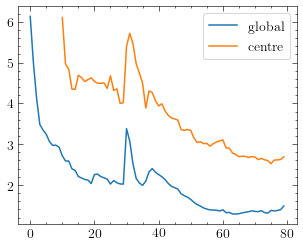

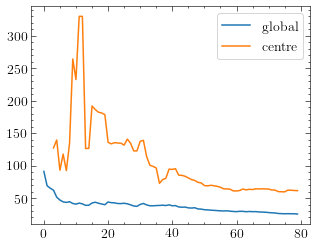

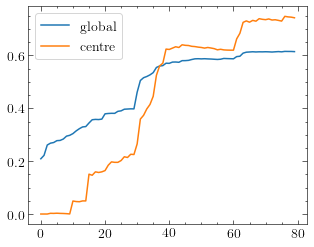

In [8]:
Ftot_master = []
Ftot_patch = []

ad_history = []
ad_centre_history = []
ofe_history = []
ofe_centre_history = []
ratio_history = []
ratio_centre_history = []

### import HILLS and position file ####################################################################################################################################################################
for file in glob.glob("HILLS40"):
    hills = np.loadtxt(file)
    hills = np.concatenate(([hills[0]], hills[:-1]))
    hills[0][5] = 0
    HILLS = hills

for file1 in glob.glob("position40"):
    colvar = np.loadtxt(file1)
    position_x = colvar[:-1, 1]
    position_y = colvar[:-1, 2]

stride = int(len(position_x)/len(HILLS))     # stride:   number of points in the COLVAR file per point in the HILLS file
const = (1 / (bw*np.sqrt(2*np.pi)*stride))

#Shorten HILLS
HILLS = HILLS[:4000]

#initialize terms
Fbias_x = np.zeros((nbins, nbins)); 
Fbias_y = np.zeros((nbins, nbins)); 
Ftot_num_x = np.zeros((nbins, nbins)); 
Ftot_num_y = np.zeros((nbins, nbins)); 
Ftot_den = np.zeros((nbins, nbins));
Ftot_den2 = np.zeros((nbins, nbins));
ofv_x = np.zeros((nbins,nbins)); 
ofv_y = np.zeros((nbins,nbins)); 
ofe = np.zeros((nbins,nbins));
total_number_of_hills=len(HILLS[:,1]); 
print("Total no. of HILLS for following simulation: " + str(total_number_of_hills))



#Cycle over the updates of the bias potential V_t(s) ####################################################################################################################################################################
for i in range(total_number_of_hills):
    
    # Build metadynamics potential
    s_x = HILLS[i, 1]  # center x-position of gausian
    s_y = HILLS[i, 2]  # center y-position of gausian
    sigma_meta2_x = HILLS[i, 3] ** 2  # width of gausian
    sigma_meta2_y = HILLS[i, 4] ** 2  # width of gausian
    gamma = HILLS[i, 6]
    height_meta = HILLS[i, 5] * ((gamma - 1) / (gamma))  # Height of Gausian
    periodic_points = find_periodic_point(s_x,s_y)
    for j in range(len(periodic_points)):
        kernelmeta = np.exp(-0.5 * (((X - periodic_points[j][0]) ** 2) / sigma_meta2_x + ((Y - periodic_points[j][1]) ** 2) / sigma_meta2_y))  # potential erorr in calc. of s-s_t
        # kernelmeta = np.where(((X-periodic_points[j][0]) ** 2 + (Y - periodic_points[j][1]) ** 2) ** (1 / 2) >= grid_ext, 0, kernelmeta)
        Fbias_x = Fbias_x + height_meta * kernelmeta * ((X - periodic_points[j][0]) / sigma_meta2_x);  ##potential erorr in calc. of s-s_t
        Fbias_y = Fbias_y + height_meta * kernelmeta * ((Y - periodic_points[j][1]) / sigma_meta2_y);  ##potential erorr in calc. of s-s_t


    # Initialise probability density
    pb_t = np.zeros((nbins, nbins))
    Fpbt_x = np.zeros((nbins, nbins))
    Fpbt_y = np.zeros((nbins, nbins))
    # Estimate the biased proabability density p_t ^ b(s)
    data_x = position_x[i * stride: (i + 1) * stride]
    data_y = position_y[i * stride: (i + 1) * stride]


    # Biased probability density component of the force
    for j in range(stride):
        periodic_points = find_periodic_point(data_x[j], data_y[j])
        for k in range(len(periodic_points)):
            kernel = const * np.exp(- (1 / (2 * bw2)) * ((X - periodic_points[k][0]) ** 2 + (Y - periodic_points[k][1]) ** 2));  # check index of j
            # kernel = np.where(((X - periodic_points[k][0]) ** 2 + (Y - periodic_points[k][1]) ** 2) ** (1 / 2) >= grid_ext, 0,kernel)
            pb_t = pb_t + kernel;
            Fpbt_x = Fpbt_x + kernel * kT * (X - periodic_points[k][0]) / bw2
            Fpbt_y = Fpbt_y + kernel * kT * (Y - periodic_points[k][1]) / bw2


    # Calculate Mean Force
    Ftot_den = Ftot_den + pb_t;
    # Calculate x-component of Force
    Fpbt_x = np.divide((Fpbt_x), pb_t, out=np.zeros_like(Fpbt_x), where=pb_t != 0)
    dfds_x = Fpbt_x + Fbias_x
    Ftot_num_x = Ftot_num_x + pb_t * dfds_x
    Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den != 0)
    # Calculate y-component of Force
    Fpbt_y = np.divide((Fpbt_y), pb_t, out=np.zeros_like(Fpbt_y), where=pb_t != 0)
    dfds_y = Fpbt_y + Fbias_y
    Ftot_num_y = Ftot_num_y + pb_t * dfds_y
    Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den != 0)

    #calculate on the fly error (ofe)
    Ftot_den2 = Ftot_den2 + pb_t**2;    
    ofv_x += pb_t * dfds_x**2
    ofv_y += pb_t * dfds_y**2
    
    
    if (i+1) % 50 == 0:
        
        
#         master0 = [np.zeros((nbins, nbins)), np.zeros((nbins, nbins)), np.zeros((nbins, nbins)), np.zeros((nbins, nbins)), np.zeros((nbins, nbins)), np.zeros((nbins, nbins))]
#         master_now = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]
#         patch_to_base_error(master0, master_now)
        
        
        
        #integrate Ftot to find FES
        FES = FFT_intg_2D(Ftot_x, Ftot_y)
         
        #Find adjusted FES (60x60) to compare to reference FES (60x60)
        FES_adj = find_FES_adj(X, Y, FES)
        FES_adj = FES_adj - np.min(FES_adj)

        #Find cutoff matrix for FES_adj > Flim
        cutoff = find_cutoff_matrix(FES_adj)

        # Calculate FES, only take every 5th (factor) value to comopare to fes[60x60]
        FES_error = abs(FES_adj - FREF) * cutoff
        ad_history.append(sum(sum(FES_error)) / (np.count_nonzero(FES_error)))
        ad_centre_history.append(sum(sum(reduce_to_centre_plumed(FES_error))) / (np.count_nonzero(reduce_to_centre_plumed(FES_error))))

        # Find cutoff matrix for FES > Flim
        cutoff = find_cutoff_matrix(FES)
        
        #calculate ofe (standard error)
        Ftot_den_ratio = np.divide(Ftot_den2, (Ftot_den**2 - Ftot_den2), out=np.zeros_like(Ftot_den), where=(Ftot_den**2 - Ftot_den2) != 0)
        ofe_x = np.divide(ofv_x, Ftot_den, out=np.zeros_like(ofv_x), where=Ftot_den != 0) - Ftot_x**2
        ofe_y = np.divide(ofv_y, Ftot_den, out=np.zeros_like(ofv_y), where=Ftot_den != 0) - Ftot_y**2
        
        ofe_x = ofe_x * Ftot_den_ratio
        ofe_y = ofe_y * Ftot_den_ratio
        

        ofe = np.sqrt(np.sqrt(ofe_x**2 + ofe_y**2))
        ofe = np.array(ofe*cutoff)
        ofe_history.append(sum(sum(ofe)) / (np.count_nonzero(ofe)))
        ofe_centre_history.append(sum(sum(reduce_to_centre(ofe))) / (np.count_nonzero(reduce_to_centre(ofe))))
        
        ratio_history.append(np.count_nonzero(cutoff)/(nbins*nbins))
        ratio_centre_history.append(np.count_nonzero(reduce_to_centre(cutoff))/ (np.shape(reduce_to_centre(cutoff))[0]*np.shape(reduce_to_centre(cutoff))[1] ))
        
        print(str(i+1) + " / " + str(total_number_of_hills))
        print("AAD (to FREF) is: " + str(ad_history[-1]) + " [" + str(ad_centre_history[-1]) + "]")
        print("ofe is: "  + str(ofe_history[-1]) + " [" + str(ofe_centre_history[-1]) + "]")
        print("With non-zero ratio: " , ratio_history[-1] , " [" , ratio_centre_history[-1] , "]")
        print("\n")


# Activate this to save Force terms
# file_name = "Ftot_master_2M005.npy"
# Ftot_master.append([Ftot_den, Ftot_x,Ftot_y, Ftot_den2, ofv_x, ofv_y])
# os.system("rm " + file_name)
# with open(file_name,"wb") as fw:
#     np.save(fw, Ftot_master)

plt.plot(range(len(ad_history)), ad_history, label="global")
plt.plot(range(len(ad_centre_history)), ad_centre_history, label="centre")
plt.legend()
plt.show()
         
plt.plot(range(len(ofe_history)), ofe_history, label="global")
plt.plot(range(len(ofe_centre_history)), ofe_centre_history, label="centre")
plt.legend()
plt.show()

plt.plot(range(len(ratio_history)), ratio_history, label="global")
plt.plot(range(len(ratio_centre_history)), ratio_centre_history, label="centre")
plt.legend()
plt.show()


In [44]:
# # Activate this to save Force terms
# Ftot_master = []
# file_name = "Ftot_master_4M005.npy"
# Ftot_master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
# os.system("rm " + file_name)
# with open(file_name,"wb") as fw:
#     np.save(fw, Ftot_master)
    
# with open("AAD_progession_4M005.npy","wb") as fw:
#     np.save(fw, ad_history)

# with open("ofe_progession_4M005.npy","wb") as fw:
#     np.save(fw, ofe_history)
    
# with open("AAD_c_progession_4M005.npy","wb") as fw:
#     np.save(fw, ad_centre_history)

# with open("ofe_c_progession_4M005.npy","wb") as fw:
#     np.save(fw, ofe_centre_history)
    
    
# with open("ratio_progession_4M005.npy","wb") as fw:
#     np.save(fw, ratio_history)

# with open("ratio_c_progession_4M005.npy","wb") as fw:
#     np.save(fw, ratio_centre_history)

In [11]:
print(os.getcwd())

/home/antoniu/Desktop/Public_Notebooks/Alanine_Dipeptide


In [15]:
# # Load Force terms from 40M simulation
# Ftot_master = []
# file_name = "Ftot_master_4M005.npy"
# Ftot_master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
# os.system("rm " + file_name)
# with open(file_name,"wb") as fw:
#     np.save(fw, Ftot_master)
    
    
Ftot_master = load_npy("Ftot_master_40M005.npy")

print(np.shape(Ftot_master))
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]  = Ftot_master[0]

ad_history = load_npy("AAD_progession_40M005.npy")

ad_centre_history = load_npy("AAD_c_progession_40M005.npy")

ofe_history = load_npy("ofe_progession_40M005.npy")

ofe_centre_history = load_npy("AAD_c_progession_40M005.npy")

ratio_history = load_npy("ratio_progession_40M005.npy")

ratio_centre_history = load_npy("ratio_c_progession_40M005.npy")
    
# with open("AAD_progession_4M005.npy","wb") as fw:
#     np.save(fw, ad_history)

# with open("ofe_progession_4M005.npy","wb") as fw:
#     np.save(fw, ofe_history)
    
# with open("AAD_c_progession_4M005.npy","wb") as fw:
#     np.save(fw, ad_centre_history)

# with open("ofe_c_progession_4M005.npy","wb") as fw:
#     np.save(fw, ofe_centre_history)
    
    
# with open("ratio_progession_4M005.npy","wb") as fw:
#     np.save(fw, ratio_history)

# with open("ratio_c_progession_4M005.npy","wb") as fw:
#     np.save(fw, ratio_centre_history)

(1, 6, 201, 201)


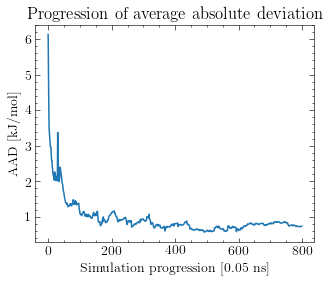

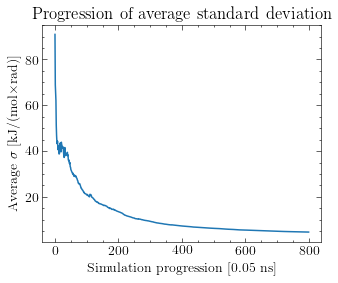

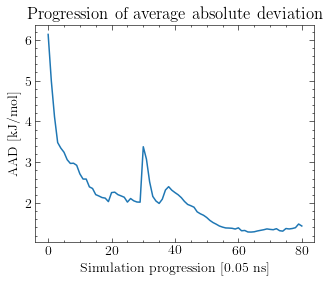

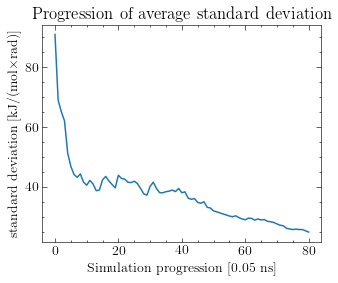

In [17]:
plt.plot(range(len(ad_history)), ad_history)
plt.xlabel("Simulation progression [0.05 ns]")
plt.ylabel("AAD [kJ/mol]")
plt.title("Progression of average absolute deviation")
plt.show()
         
plt.plot(range(len(ofe_history)), ofe_history)
plt.xlabel("Simulation progression [0.05 ns]")
plt.ylabel("Average $\sigma$ [kJ/(mol" + r"$\times$" + "rad)]")
plt.title("Progression of average standard deviation")
plt.show()


plt.plot(range(len(ad_history[:81])), ad_history[:81])
plt.xlabel("Simulation progression [0.05 ns]")
plt.ylabel("AAD [kJ/mol]")
plt.title("Progression of average absolute deviation")
plt.show()
         
plt.plot(range(len(ofe_history[:81])), ofe_history[:81])
plt.xlabel("Simulation progression [0.05 ns]")
plt.ylabel("standard deviation [kJ/(mol" + r"$\times$" + "rad)]")
plt.title("Progression of average standard deviation")
plt.show()

AAD (to FREF) is: 2.3136129056493173
Average standard error is: 0.007929864253375331
With non-zero ratio:  0.5706789435905052
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



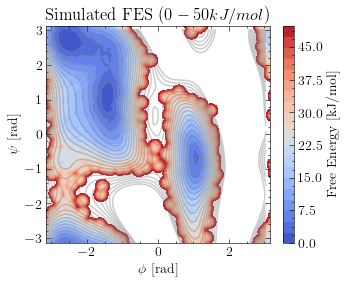

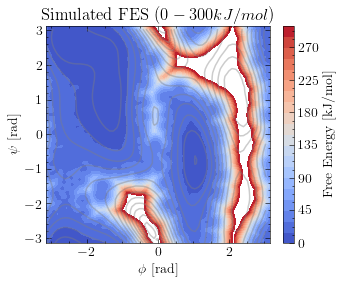

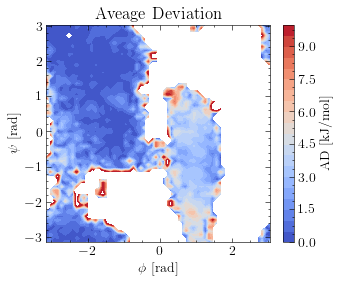

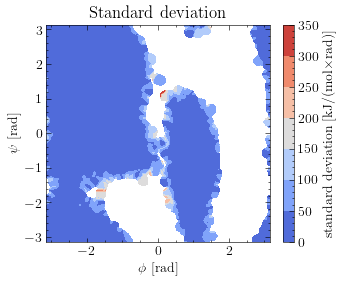

In [18]:
with open("Ftot_master_2M005.npy", "rb") as data:
#     loaded = np.load(data)
#     print(np.shape(loaded))
    [Ftot_den0, Ftot_den20, Ftot_x0, Ftot_y0, ofv_x0, ofv_y0] = np.load(data)[0]

    

# [Ftot_den0, Ftot_x0, Ftot_y0] = loaded[0]

# FES = FFT_intg_2D(Ftot_x0, Ftot_y0)
    
# 

Ftot_master = [[Ftot_den0, Ftot_den20, Ftot_x0, Ftot_y0, ofv_x0, ofv_y0]]
Ftot_patch = []
error_patch = []
sd_patch = []
    
[FES, FES_error] = patch2D_error()


plt.figure(1)
plt.contourf(X, Y, FES, levels=np.linspace(0, 50, 21), cmap='coolwarm')
plt.title("Simulated FES ($0-50 kJ/mol$)")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(XREF, YREF, FREF, levels=np.linspace(0, 50, 21), alpha=0.4, colors="grey")
# plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/FES50_AP_2M.png', dpi=600, bbox_inches='tight')


plt.figure(2)
plt.contourf(X, Y, FES, levels=np.linspace(0, 300, 21), cmap='coolwarm')
plt.title("Simulated FES ($0-300 kJ/mol$)")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(XREF, YREF, FREF, levels=np.linspace(0, 150, 21), alpha=0.4, colors="grey")
# plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/FES150_AP_40M.png', dpi=600, bbox_inches='tight')



plt.figure(3)
plt.contourf(XREF, YREF, zero_to_nan(FES_error), levels=np.linspace(0, 10, 21), cmap='coolwarm')
plt.title("Aveage Deviation")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.colorbar(label="AD [kJ/mol]")
# plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/AD_AP_2M.png', dpi=600, bbox_inches='tight')




plt.figure(4)
plt.contourf(X, Y, zero_to_nan(ofe), cmap='coolwarm')
plt.title("Standard deviation")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.colorbar(label="standard deviation [kJ/(mol" + r"$\times$" + "rad)]")
# plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/ofe_AP_40M.png', dpi=600, bbox_inches='tight')




# plt.figure(4)
# plt.contourf(XREF, YREF, zero_to_nan(FES_error_uncut), levels=np.linspace(0, 80, 21), cmap='coolwarm')
# plt.colorbar()
# plt.contour(XREF, YREF, zero_to_nan(FES_error_uncut), levels=np.linspace(50, 150, 5), alpha=0.5, colors="grey")
# ax2.set_title("AD to FES10E9 UNCUT")
# ax2.set_xlabel("phi")
# ax2.set_ylabel("psi")


plt.show()


# Metadynamcis simulation with static bias (patch with MetaD sim)

In [19]:
os.chdir("/home/antoniu/Desktop/Public_Notebooks/Alanine_Dipeptide/")


with open("Ftot_master_2M005.npy", "rb") as data:
    [Ftot_den0, Ftot_den20, Ftot_x0, Ftot_y0, ofv_x0, ofv_y0] = np.load(data)[0]
    
with open("AAD_progession_2M005.npy", "rb") as data:
    ad_history = np.load(data)
ad_history = ad_history.tolist()
    
with open("ofe_progession_2M005.npy", "rb") as data:
    ofe_history = np.load(data)
ofe_history = ofe_history.tolist()

with open("AAD_c_progession_2M005.npy", "rb") as data:
    ad_centre_history = np.load(data)
ad_centre_history = ad_centre_history.tolist()
    
with open("ofe_c_progession_2M005.npy", "rb") as data:
    ofe_centre_history = np.load(data)
ofe_centre_history = ofe_centre_history.tolist()


with open("ratio_progession_2M005.npy", "rb") as data:
    ratio_history = np.load(data)
ratio_history = ratio_history.tolist()

with open("ratio_c_progession_2M005.npy", "rb") as data:
    ratio_centre_history = np.load(data)
ratio_centre_history = ratio_centre_history.tolist()
  
# master_zero = [np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins))]
master0 = [Ftot_den0, Ftot_den20, Ftot_x0, Ftot_y0, ofv_x0, ofv_y0]

# patch_to_base_error(master_zero, master0)

Ftot_master = [master0]
Ftot_patch = []

FES_error_history = []
FES_history = []

[FES, FES_error] = patch2D_error()

FES_error_history.append(FES_error)
FES_history.append(FES)



# print(np.shape(Ftot_master))
# print(np.shape(Ftot_patch))

AAD (to FREF) is: 2.3136129056493173
Average standard error is: 0.007929864253375331
With non-zero ratio:  0.5706789435905052
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [20]:
simulation_count = 1

ipos_x = ["0.0"]#,"-2.0"]
ipos_y = ["0.0","-2.0","-2.0"]

ipos_x = ["-2.0"]
ipos_y = ["-2.0","-2.0"]
kappa = [100,100,100,100,100,100,100,100,100]

nsteps = 500000

# os.system("rm bck.*")
# os.system("rm structure*")
# os.system("rm input*")
# os.system("rm *.*#")
# Ftot_patch = []
# error_patch = []

for simulation in range(len(ipos_x)):
    simulation_count += 1

    #Find index of x restraint
    IPOSX = int((float(ipos_x[simulation]) - np.min(grid)) // grid_space)
    ipos_x[simulation] = str(grid[IPOSX])
    # Find index of y restraint
    IPOSY = int((float(ipos_y[simulation]) - np.min(grid)) // grid_space)
    ipos_y[simulation] = str(grid[IPOSY])
    # print("New x-wall (lower/upper) adjusted to grid: ", (grid[LX_wall], grid[UX_wall]), (diff1x, diff2x))


    #'''
    #####>>>Analyse trajectorry <- input traj_comp2.xtc>>>##############################
    #PBC havent been used for start_region (below)
    start_region = [str( float(ipos_x[simulation]) - 0.5), str( float(ipos_x[simulation]) + 0.5), str( float(ipos_y[simulation]) - 0.5), str( float(ipos_y[simulation]) + 0.5)]
    print("Preparing new input files ...")
    with open("plumed_traj.dat") as f:
        lines = f.readlines()
    lines[3] = "UPDATE_IF ARG=phi,psi MORE_THAN=" + start_region[0] + "," + start_region[2] + " LESS_THAN=" + start_region[1] + "," + start_region[3] + "\n"
    lines[4] = "DUMPATOMS FILE=structure" + str(simulation_count) + ".gro ATOMS=1-22\n"
    with open("plumed_traj.dat", "w") as f:
        f.writelines(lines)

    os.system("plumed driver --plumed plumed_traj.dat --mf_xtc 0traj_comp.xtc > /dev/null") #
    #####<<<Analyse trajectorry -> output new structure(n).gro<<<##############################


    #####>>>Prepare new input file<- input structure(n).gro, topolvac.top, gromppvac.mdp >>>##############################
    # print("Writing new .trp file ...")
    # os.system("gmx grompp -f gromppvac.mdp -c structure" + str(simulation_count) + ".gro -p topology.top -o input" + str(simulation_count) + ".tpr > /dev/null") #
    find_input_structure = subprocess.Popen(["gmx", "grompp", "-f", "gromppvac.mdp", "-c", "structure" + str(simulation_count)+".gro", "-p", "topology.top", "-o", "input" + str(simulation_count)+ ".tpr"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    find_input_structure.wait()
    output_find_input_structure, errors_find_input_structure = find_input_structure.communicate()
    if "Error" in errors_find_input_structure:
        print("*****There is an error message:*****\n\n")
        print(errors_find_input_structure)
    #####<<<Prepare new input file input(n).tpr<<<##############################


    #####>>>Change simulation parameters in plumed.dat>>>##############################
    with open("plumed_restr.dat", "w") as f:
        print("""MOLINFO STRUCTURE=reference.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
RESTRAINT ARG=phi,psi AT=0.0,0.0 KAPPA=125.0,125.0 LABEL=restraint
METAD ARG=phi,psi SIGMA=0.2,0.2 HEIGHT=1.2 PACE=500 TEMP=300 BIASFACTOR=8 GRID_MIN=-pi,-pi GRID_MAX=pi,pi GRID_BIN=500,500
PRINT FILE=position ARG=phi,psi STRIDE=50
PRINT FILE=restraint ARG=phi,psi,restraint.bias,restraint.force2 STRIDE=100

#gmx mdrun -s topolA.tpr -nsteps 1000000 -plumed plumed_first.dat -v""", file=f)

    with open("plumed_restr.dat") as f:
        lines = f.readlines()

    lines[3] = "RESTRAINT ARG=phi,psi AT=" + ipos_x[simulation] + "," + ipos_y[simulation] + " KAPPA=" + str(kappa[simulation]) + "," + str(kappa[simulation]) + " LABEL=restraint\n"
    lines[4] = "METAD ARG=phi,psi PACE=500 SIGMA=0.1,0.1 HEIGHT=0.5 TEMP=300 BIASFACTOR=3 GRID_MIN=-pi,-pi GRID_MAX=pi,pi GRID_BIN=1000,1000\n"

    with open("plumed_restr.dat", "w") as f:
        f.writelines(lines)
    #####<<<Change simulation parameters in plumed.dat<<<##############################


    #####>>>run new simulations>>>##############################
    print("Running simulation with harmonic potential at: (" , round(float(ipos_x[simulation]),2) , "," , round(float(ipos_y[simulation]),2) , ")  with kappa =" , str(kappa[simulation]))
    # os.system("gmx mdrun -s input" + str(simulation_count) + ".tpr -nsteps " + str(int(nsteps)) + " -plumed plumed_restr.dat -v") # > /dev/null
    find_input_file = subprocess.Popen(["gmx", "mdrun", "-s", "input" + str(simulation_count) + ".tpr", "-nsteps" , str(int(nsteps)), "-plumed", "plumed_restr.dat"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    find_input_file.wait()
    output_find_input_file, errors_find_input_file = find_input_file.communicate()

    if "Error" in errors_find_input_file:
        print("There is an error message")
        print(errors_find_input_file)

    print("... Simulation finished. Analysing data ...\n")

    #####<<<run new simulations<<<##############################
    #'''

    ### import HILLS and position file ####################################################################################################################################################################
    for file in glob.glob("HILLS"):
        hills = np.loadtxt(file)
        hills = np.concatenate(([hills[0]], hills[:-1]))
        hills[0][5] = 0
        HILLS = hills

    for file1 in glob.glob("position"):
        colvar = np.loadtxt(file1)
        position_x = colvar[:-1, 1]
        position_y = colvar[:-1, 2]


    stride = int(len(position_x)/len(HILLS))
    const = (1 / (bw * np.sqrt(2 * np.pi) * stride))

#     plt.figure(0)
#     plt.scatter(position_x, position_y,s=1, label="Sim. " + str(simulation))
#     plt.xlim(-np.pi, np.pi)
#     plt.ylim(-np.pi, np.pi)
#     plt.xlabel("phi")
#     plt.ylabel("psi")
#     plt.title("COLVAR coordinates")
#     plt.legend()
    # plt.show()


    ######### FIND HARMONIC FORCE (taking into account PBC)##################
    F_harmonic_x = np.zeros((len(grid), len(grid)))
    F_harmonic_y = np.zeros((len(grid), len(grid)))
    #Calculate x-force
    if abs(grid[IPOSX]) < grid_space: F_harmonic_x = kappa[simulation] * (X - grid[IPOSX])
    elif grid[IPOSX] < 0:
        SEPR = round((grid[IPOSX] + 2*np.pi) / grid_space)
        F_harmonic_x[:, :SEPR] += kappa[simulation] * (X[:, :SEPR] - grid[IPOSX])
        F_harmonic_x[:, SEPR:] += kappa[simulation] * (X[:, SEPR:] - grid[IPOSX] - (np.max(grid) - np.min(grid)))
    elif grid[IPOSX] > 0:
        SEPR = round((grid[IPOSX]) / grid_space)
        F_harmonic_x[:, :SEPR] += kappa[simulation] * (X[:, :SEPR] - grid[IPOSX] + (np.max(grid) - np.min(grid)))
        F_harmonic_x[:, SEPR:] += kappa[simulation] * (X[:, SEPR:] - grid[IPOSX])
    #Calculate y-force
    if abs(grid[IPOSY]) < grid_space: F_harmonic_y = kappa[simulation] * (Y - grid[IPOSY])
    elif grid[IPOSY] < 0:
        SEPR = round((grid[IPOSY] + 2*np.pi) / grid_space)
        F_harmonic_y[:SEPR, :] += kappa[simulation] * (Y[:SEPR, :] - grid[IPOSY])
        F_harmonic_y[SEPR:, :] += kappa[simulation] * (Y[SEPR:, :] - grid[IPOSY] - (np.max(grid) - np.min(grid)))
    elif grid[IPOSY] > 0:
        SEPR = round((grid[IPOSY]) / grid_space)
        F_harmonic_y[:SEPR, :] += kappa[simulation] * (Y[:SEPR, :] - grid[IPOSY] + (np.max(grid) - np.min(grid)))
        F_harmonic_y[SEPR:, :] += kappa[simulation] * (Y[SEPR:, :] - grid[IPOSY])

    F_harmonic = F_harmonic_x + F_harmonic_y




    P_harmonic_x = np.zeros((len(grid), len(grid)))
    P_harmonic_y = np.zeros((len(grid), len(grid)))
    #Calculate x-force
    if abs(grid[IPOSX]) < grid_space: P_harmonic_x = kappa[simulation]/2 * (X - grid[IPOSX])**2
    elif grid[IPOSX] < 0:
        SEPR = round((grid[IPOSX] + 2*np.pi) / grid_space)
        P_harmonic_x[:, :SEPR] += kappa[simulation]/2 * (X[:, :SEPR] - grid[IPOSX])**2
        P_harmonic_x[:, SEPR:] += kappa[simulation]/2 * (X[:, SEPR:] - grid[IPOSX] - (np.max(grid) - np.min(grid)))**2
    elif grid[IPOSX] > 0:
        SEPR = round((grid[IPOSX]) / grid_space)
        P_harmonic_x[:, :SEPR] += kappa[simulation]/2 * (X[:, :SEPR] - grid[IPOSX] + (np.max(grid) - np.min(grid)))**2
        P_harmonic_x[:, SEPR:] += kappa[simulation]/2 * (X[:, SEPR:] - grid[IPOSX])**2
    #Calculate y-force
    if abs(grid[IPOSY]) < grid_space: P_harmonic_y = kappa[simulation]/2 * (Y - grid[IPOSY])**2
    elif grid[IPOSY] < 0:
        SEPR = round((grid[IPOSY] + 2*np.pi) / grid_space)
        P_harmonic_y[:SEPR, :] += kappa[simulation]/2 * (Y[:SEPR, :] - grid[IPOSY])**2
        P_harmonic_y[SEPR:, :] += kappa[simulation]/2 * (Y[SEPR:, :] - grid[IPOSY] - (np.max(grid) - np.min(grid)))**2
    elif grid[IPOSY] > 0:
        SEPR = round((grid[IPOSY]) / grid_space)
        P_harmonic_y[:SEPR, :] += kappa[simulation]/2 * (Y[:SEPR, :] - grid[IPOSY] + (np.max(grid) - np.min(grid)))**2
        P_harmonic_y[SEPR:, :] += kappa[simulation]/2 * (Y[SEPR:, :] - grid[IPOSY])**2

    P_harmonic = P_harmonic_x + P_harmonic_y



    for file1 in glob.glob("restraint"):
        data = np.loadtxt(file1)
        restr_pos = data[:, 1:3]
        # restr_psi = data[:, 2]
        plumed_bias = (data[:, 3])
        plumed_force2 = (data[:, 4])


    bias_error = []
    bias_interpolate = interpolate.interp2d(grid, grid, P_harmonic, kind="quintic")
    # force_interpolate = interpolate.interp2d(grid, grid, F_harmonic, kind="quintic")

    for ii in range(len(plumed_bias)):
        bias_error.append(bias_interpolate(restr_pos[ii][0], restr_pos[ii][1]) - plumed_bias[ii])
    bias_error = np.array(bias_error).reshape((np.shape(bias_error)[0],))
    if sum(bias_error)/(len(bias_error)) > 1:
        print("\n\n******** ATTENTION, BIAS DIFFERENCE IS HIGH **********")
        print("Plumed Bias vs theoretical Bias difference: " , sum(bias_error)/(len(bias_error)))

        bias_error_interploation = griddata(restr_pos, np.array(bias_error), (X, Y), method="linear")

        plumed_bias_interpolate = griddata(restr_pos, np.array(plumed_bias), (X, Y), method="linear")

        fig_restr = plt.figure(2)

        ax1 = fig_restr.add_subplot(131)
        im1 = ax1.contourf(X, Y, bias_error_interploation, cmap='coolwarm')
        ax1.set_title("bias error interploation")
        ax1.set_xlabel("phi")
        ax1.set_ylabel("psi")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig_restr.colorbar(im1, cax=cax, orientation='vertical');

        ax3 = fig_restr.add_subplot(132)
        im3 = ax3.contourf(X, Y, plumed_bias_interpolate, cmap='coolwarm')
        ax3.set_title("plumed bias interpolate")
        ax3.set_xlabel("phi")
        ax3.set_ylabel("psi")
        divider = make_axes_locatable(ax3)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig_restr.colorbar(im3, cax=cax, orientation='vertical');

        ax4 = fig_restr.add_subplot(133)
        im4 = ax4.contourf(X, Y, P_harmonic, cmap='coolwarm')
        ax4.set_title("P harmonic")
        ax4.set_xlabel("phi")
        ax4.set_ylabel("psi")
        divider = make_axes_locatable(ax4)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig_restr.colorbar(im4, cax=cax, orientation='vertical');

        plt.show()


    #"""

    # initialize Force terms
    Fbias_x = np.zeros((nbins, nbins)) ; 
    Fbias_y = np.zeros((nbins, nbins)) ; 
    Ftot_num_x = np.zeros((nbins, nbins)) ; 
    Ftot_num_y = np.zeros((nbins, nbins))
    Ftot_den = np.zeros((nbins, nbins)) ; 
    Ftot_den2 = np.zeros((nbins, nbins)) ; 
    ofv_x = np.zeros((nbins, nbins))
    ofv_y = np.zeros((nbins, nbins))
    count = 0 ; 
    total_number_of_hills = len(HILLS)
    print("Calculate Force Terms (" + str(total_number_of_hills) + " HILLS) ...")

  
    # Cycle over the updates of the bias potential V_t(s) ####################################################################################################################################################################
    for i in range(total_number_of_hills):
        count += 1

        # Build metadynamics potential
        s_x = HILLS[i, 1] ;
        s_y = HILLS[i, 2]
        sigma_meta2_x = HILLS[i, 3] ** 2 ; 
        sigma_meta2_y = HILLS[i, 4] ** 2  # width of gausian
        gamma = HILLS[i, 6]; 
        height_meta = HILLS[i, 5] * ((gamma - 1) / (gamma))  # Height of Gausian

        periodic_points = find_periodic_point(s_x, s_y)
        for j in range(len(periodic_points)):
            kernelmeta = np.exp(-0.5 * (((X - periodic_points[j][0]) ** 2) / sigma_meta2_x + ((Y - periodic_points[j][1]) ** 2) / sigma_meta2_y))  # potential erorr in calc. of s-s_t
            # kernelmeta = np.where(((X-periodic_points[j][0]) ** 2 + (Y - periodic_points[j][1]) ** 2) ** (1 / 2) >= grid_ext, 0, kernelmeta)
            Fbias_x = Fbias_x + height_meta * kernelmeta * ((X - periodic_points[j][0]) / sigma_meta2_x);  ##potential erorr in calc. of s-s_t
            Fbias_y = Fbias_y + height_meta * kernelmeta * ((Y - periodic_points[j][1]) / sigma_meta2_y);  ##potential erorr in calc. of s-s_t


        # Initialise probability density
        pb_t = np.zeros((nbins, nbins))
        Fpbt_x = np.zeros((nbins, nbins))
        Fpbt_y = np.zeros((nbins, nbins))
        # Estimate the biased proabability density p_t ^ b(s)
        data_x = position_x[i * stride: (i + 1) * stride]
        data_y = position_y[i * stride: (i + 1) * stride]

        # Biased probability density component of the force
        for j in range(stride):
            periodic_points = find_periodic_point(data_x[j], data_y[j])
            for k in range(len(periodic_points)):
                # kernel = const * np.exp( - (1 / (2 * bw2)) * ((X - data_x[j]) ** 2 + (Y - data_y[j]) ** 2));  # check index of j
                kernel = const * np.exp(- (1 / (2 * bw2)) * ((X - periodic_points[k][0]) ** 2 + (Y - periodic_points[k][1]) ** 2));  # check index of j
                # kernel = np.where(((X - periodic_points[k][0]) ** 2 + (Y - periodic_points[k][1]) ** 2) ** (1 / 2) >= grid_ext, 0,kernel)
                pb_t = pb_t + kernel;
                Fpbt_x = Fpbt_x + kernel * kT * (X - periodic_points[k][0]) / bw2
                Fpbt_y = Fpbt_y + kernel * kT * (Y - periodic_points[k][1]) / bw2


        # Calculate Mean Force
        Ftot_den = Ftot_den + pb_t;
        # Calculate x-component of Force
        Fpbt_x = np.divide((Fpbt_x), pb_t, out=np.zeros_like(Fpbt_x), where=pb_t != 0)
        dfds_x = Fpbt_x + Fbias_x - F_harmonic_x
        Ftot_num_x = Ftot_num_x + pb_t * dfds_x
        Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den != 0)
        # Calculate y-component of Force
        Fpbt_y = np.divide((Fpbt_y), pb_t, out=np.zeros_like(Fpbt_y), where=pb_t != 0)
        dfds_y = Fpbt_y + Fbias_y - F_harmonic_y
        Ftot_num_y = Ftot_num_y + pb_t * dfds_y
        Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den != 0)
        
        #calculate on the fly error (ofe)
        Ftot_den2 = Ftot_den2 + pb_t**2;    
        ofv_x += pb_t * dfds_x**2
        ofv_y += pb_t * dfds_y**2
        
        
        if (i+1) % 50 == 0:
            master_now = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]
#             master_now = [np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins))]
            [FES, FES_error] =   patch_to_base_error(master0, master_now)
#             patch_to_base_error(master0, master0)

            FES_history.append(FES)
            FES_error_history.append(FES_error)
#     
    


    Ftot_master.append([Ftot_den, Ftot_den2 ,Ftot_x, Ftot_y, ofv_x, ofv_y])




    print("Patching Force Terms ( Shape of master: ",np.shape(Ftot_master))
    
    
    [FES, FES_error] = patch2D_error()
    
    FES_history.append(FES)
    FES_error_history.append(FES_error)

    
    
#     Ftot_x = np.zeros((nbins, nbins))
#     Ftot_y = np.zeros((nbins, nbins))
#     Ftot_den = np.zeros((nbins, nbins))

#     for i in range(len(Ftot_master)):
#         Ftot_x += Ftot_master[i][0] * Ftot_master[i][1]
#         Ftot_y += Ftot_master[i][0] * Ftot_master[i][2]
#         Ftot_m += Ftot_master[i][0] * Ftot_master[i][3]
#         Ftot_den += Ftot_master[i][0]

#     Ftot_x = np.divide(Ftot_x, Ftot_den, out=np.zeros_like(Ftot_x), where=Ftot_den != 0)
#     Ftot_y = np.divide(Ftot_y, Ftot_den, out=np.zeros_like(Ftot_y), where=Ftot_den != 0)
#     Ftot_m = np.divide(Ftot_m, Ftot_den, out=np.zeros_like(Ftot_m), where=Ftot_den != 0)

#     Ftot_patch.append([Ftot_den, Ftot_x, Ftot_y, Ftot_m])

    


#     FES = FFT_intg_2D(Ftot_x, Ftot_y)

#     # print("shape FES: " , np.shape(FES_a))
#     if len(FES) == len(X): FES_adj = find_FES_adj(X, Y, FES)
#     else: FES_adj = find_FES_adj(X_new,Y_new, FES_a)
#     FES_adj = FES_adj - np.min(FES_adj)

#     # Find cutoff matrix for FES_adj > Flim
#     cutoff_adj = find_cutoff_matrix(FES_adj)

#     # Calculate FES error to FREF[60x60]
#     FES_error = abs(FES_adj - FREF) * cutoff_adj
#     FES_error_uncut_a = abs(FES_adj - FREF)
#     error_patch.append(sum(sum(FES_error)) / (np.count_nonzero(FES_error)))

#     # Find cutoff matrix for FES > Flim
#     cutoff = find_cutoff_matrix(FES)

#     print("AAD (to FREF) is: " + str(error_patch[-1]) + str("     <-------------"))
#     print("With non-zero ratio: ", np.count_nonzero(cutoff) / (np.shape(cutoff)[0] * np.shape(cutoff)[1]))
#     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")




# file_name = "Ftot_master_static.npy"
# Ftot_save = [X, Y, Ftot_den, Ftot_x,Ftot_y, FES]
# os.system("rm " + file_name)
# with open(file_name,"wb") as fw:
#     np.save(fw, Ftot_master)

print("file saved\n~~~~~~~~~~~~~~~~~~~")



Preparing new input files ...
Running simulation with harmonic potential at: ( -2.01 , -2.01 )  with kappa = 100
... Simulation finished. Analysing data ...

Calculate Force Terms (1000 HILLS) ...
AAD (to FREF) is: 2.299259720803081 [4.131262341537554]
ofe is: 38.00266943665734 [94.6302670805539]
With non-zero ratio:  0.577955991188337  [ 0.6254668930390492 ]


AAD (to FREF) is: 2.4859130253584314 [4.301967751794978]
ofe is: 37.434269956042606 [95.0503925205663]
With non-zero ratio:  0.5810747258731219  [ 0.6302207130730051 ]


AAD (to FREF) is: 2.57701283233669 [4.4257281143005]
ofe is: 36.830609905084515 [95.11197778277523]
With non-zero ratio:  0.5817925298878741  [ 0.631578947368421 ]


AAD (to FREF) is: 2.712675261776559 [4.516528516365054]
ofe is: 36.262625166750446 [95.37375553662037]
With non-zero ratio:  0.5828568599787134  [ 0.634974533106961 ]


AAD (to FREF) is: 2.882411838397468 [4.694871406454683]
ofe is: 35.98770312660309 [95.64215615772137]
With non-zero ratio:  0.58325

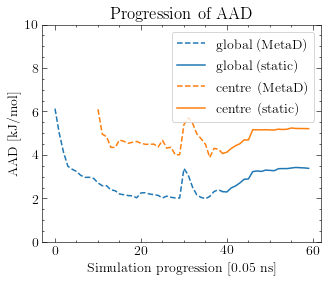

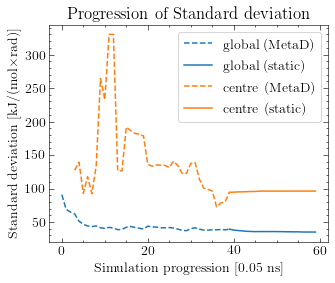

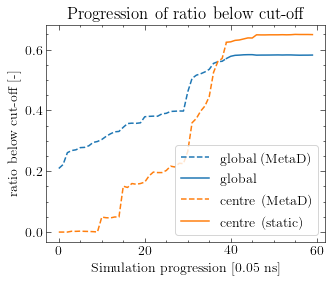

In [21]:
plt.plot(range(len(ad_history))[:40], ad_history[:40], label="global (MetaD)", ls="--", c="C0")
plt.plot(range(len(ad_history))[39:], ad_history[39:], label="global (static)")
plt.plot(range(len(ad_centre_history))[:40], ad_centre_history[:40], label="centre (MetaD)", ls="--", c="C1")
plt.plot(range(len(ad_centre_history))[39:], ad_centre_history[39:], label="centre (static)")
plt.legend()
plt.xlabel("Simulation progression [0.05 ns]")
plt.ylabel("AAD [kJ/mol]")
plt.title("Progression of AAD")
plt.ylim(0,10)
# plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/AAD_progr_AP_staticpatch.png', dpi=600, bbox_inches='tight')
plt.show()
         
plt.plot(range(len(ofe_history))[:40], ofe_history[:40], label="global (MetaD)", ls="--", c="C0")
plt.plot(range(len(ofe_history))[39:], ofe_history[39:], label="global (static)")
plt.plot(range(len(ofe_centre_history))[:40], ofe_centre_history[:40], label="centre (MetaD)", ls="--", c="C1")
plt.plot(range(len(ofe_centre_history))[39:], ofe_centre_history[39:], label="centre (static)")
plt.legend()
plt.xlabel("Simulation progression [0.05 ns]")
plt.ylabel("Standard deviation [kJ/(mol" + r"$\times$" + "rad)]")
plt.title("Progression of Standard deviation")
# plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/ofe_progr_AP_staticpatch.png', dpi=600, bbox_inches='tight')
plt.show()

plt.plot(range(len(ratio_history))[:40], ratio_history[:40], label="global (MetaD)", ls="--", c="C0")
plt.plot(range(len(ratio_history))[39:], ratio_history[39:], label="global")
plt.plot(range(len(ratio_centre_history))[:40], ratio_centre_history[:40], label="centre (MetaD)", ls="--", c="C1")
plt.plot(range(len(ratio_centre_history))[39:], ratio_centre_history[39:], label="centre (static)")
plt.legend()
plt.xlabel("Simulation progression [0.05 ns]")
plt.ylabel("ratio below cut-off [-]")
plt.title("Progression of ratio below cut-off")
plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/ofe_progr_AP_ratio.png', dpi=600, bbox_inches='tight')
plt.show()

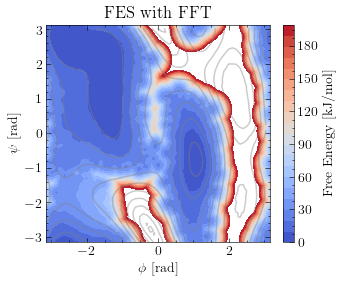

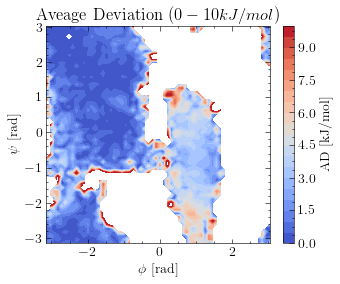



 ~~~~~ DIFFERENT SIMULATION METHOD ~~~~~




<ipython-input-22-aa70da1134b5>:32: UserWarning: No contour levels were found within the data range.
  plt.contour(XREF, YREF, FREF, levels=np.linspace(0, 5200, 21), alpha=0.4, colors="grey")


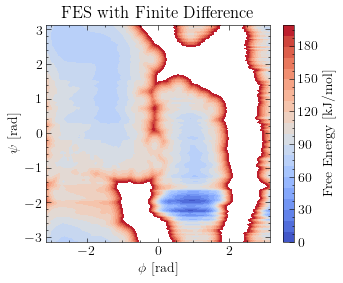

In [22]:
FES = FFT_intg_2D(Ftot_patch[1][2],Ftot_patch[1][3])

plt.figure(1)
plt.contourf(X, Y, FES, levels=np.linspace(0, 200, 21), cmap='coolwarm')
plt.title("FES with FFT")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(XREF, YREF, FREF, levels=np.linspace(0, 200, 21), alpha=0.4, colors="grey")



plt.figure(3)
plt.contourf(XREF, YREF, zero_to_nan(FES_error_history[1]), levels=np.linspace(0, 10, 21), cmap='coolwarm')
plt.title("Aveage Deviation ($0-10 kJ/mol$)")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.colorbar(label="AD [kJ/mol]")
plt.show()


print("\n\n ~~~~~ FINITE DIFFERENCE INTEGRATION METHOD ~~~~~\n\n")

FES = MS_intg_2d(Ftot_patch[1][2],Ftot_patch[1][3])

plt.figure(1)
plt.contourf(X, Y, FES, levels=np.linspace(0, 200, 21), cmap='coolwarm')
plt.title("FES with Finite Difference")
plt.xlabel("$\phi$ [rad]")
plt.ylabel("$\psi$ [rad]")
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(XREF, YREF, FREF, levels=np.linspace(0, 5200, 21), alpha=0.4, colors="grey")
plt.savefig('/home/antoniu/Desktop/Windows/Graphs_Report/FES_finitedifference.png', dpi=600, bbox_inches='tight')


plt.show()